# Aprendizaje supervisado en Python

En esta sección introductoria, aprovecharemos para hacer algunas configuraciones y definiciones que nos serán útiles a lo largo del resto del documento.

Comenzaremos por desactivar los *warnings* de tipo *Deprecation* para evitar que algunas bibliotecas que aún usen características de versiones anteriores de *scikit-learn* emitan una gran cantidad de mensajes que pueda hacer muy difícil de seguir la traza de los algoritmos y sus resultados.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

A continuación, vamos a definir una función que se encargará de hacer ajuste de parámetros de un determinado algoritmo, de acuerdo a los parámetros pasados como argumento, y que mostrará un informe con los resultados obtenidos. Esta función la usaremos en varios puntos del documento para automatizar el proceso de ajuste de parámetros.

In [2]:
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import classification_report
from sklearn.metrics         import confusion_matrix

def doGridSearch(model, grid, scores, X_train, y_train, X_test, y_test, columns, indices):
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf=GridSearchCV(model, grid, cv=10, scoring='%s' % score, iid=False)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()

        means=clf.cv_results_['mean_test_score']
        stds =clf.cv_results_['std_test_score']

        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

        conf=pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            columns=columns,
            index  =indices
        )
        print(conf)
        
        return clf.best_estimator_

Una vez hecho esto, pasamos a desarrollar los ejercicios propuestos.

## Ejercicio 1: Árboles de decisión y Random Forest

### Ejercicio 1.1: Revisitando el ejercicio de R

Como decíamos al principio, vamos a retomar los ejercicios propuestos en el módulo de R pero, en esta ocasión, los vamos a resolver en *Python*.

El primero de estos ejemplos era el de predecir el material de un objeto a partir de la información devuelta por un Sonar.

Como siempre, lo primero que tenemos que hacer es cargar los datos.

In [3]:
import pandas as pd

col_names=["V"+str(i) for i in range(1, 61)]
col_names=col_names+["Class"]

df=pd.read_csv('./data/sonar.all-data', names=col_names)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V52,V53,V54,V55,V56,V57,V58,V59,V60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


Una vez cargados los datos, los dividimos en conjunto de aprendizaje y otro de validación.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df.drop(["Class"], axis=1), df["Class"], test_size=0.3, random_state=1)

Construimos nuestro clasificador y lo entrenamos con los datos que acabamos de preparar.

In [5]:
from sklearn.tree import DecisionTreeClassifier

tree=DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Y hacemos la predicción de los datos de test y calculamos sus estadísticas y la matrix de confusión.

In [6]:
from sklearn.metrics import classification_report

y_pred=tree.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Metal', 'Predicted Rock'],
    index  =['True Metal', 'True Rock']
)
print(conf)

              precision    recall  f1-score   support

           M       0.66      0.78      0.71        32
           R       0.72      0.58      0.64        31

    accuracy                           0.68        63
   macro avg       0.69      0.68      0.68        63
weighted avg       0.69      0.68      0.68        63

            Predicted Metal  Predicted Rock
True Metal               25               7
True Rock                13              18


Por último, podemos pintarlo con las utilidades que nos proporciona *Graphviz* (siempre que la herramienta se encuentre instalada en el sistema).

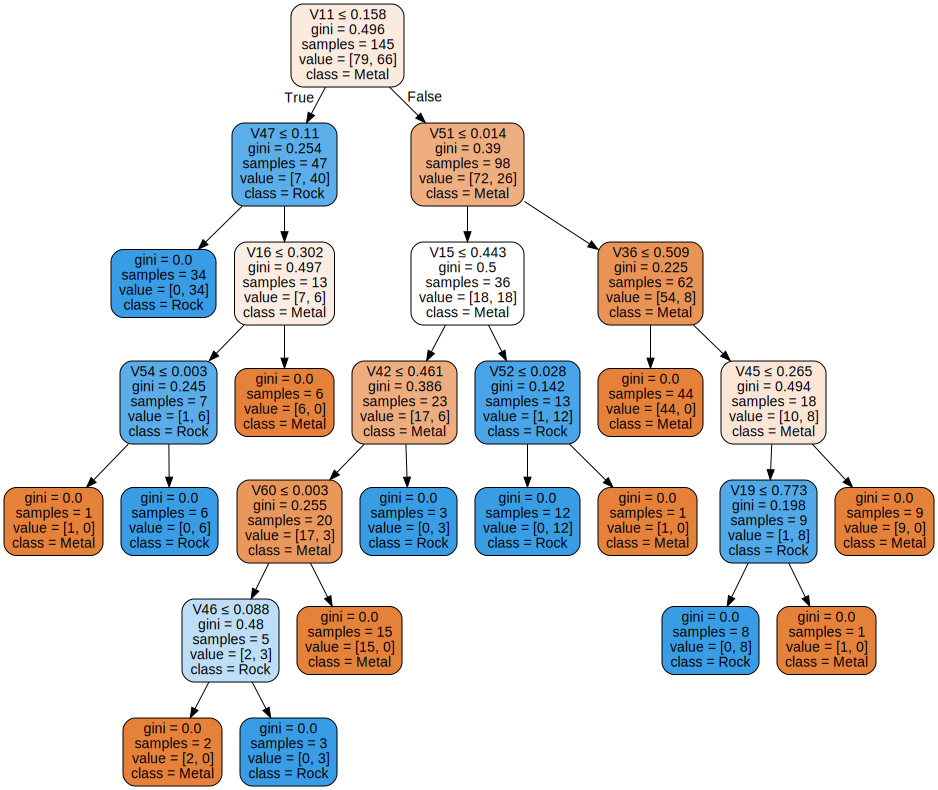

In [7]:
from sklearn import tree as t
import graphviz

dot_data=t.export_graphviz(tree, out_file=None, 
                        feature_names=X_test.columns,  
                        class_names=["Metal", "Rock"],
                        filled=True, rounded=True,  
                        special_characters=True)  
graph=graphviz.Source(dot_data)  
graph 

En *Python* no existe la posibilidad de hacer *"post-prunning"*, por lo que en caso de querer simplificar el modelo deberíamos hacerlo durante su construcción, con las opciones de *"pre-prunning"* que nos ofrece.

Probamos con algunas de las opciones que nos ofrece.

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree=DecisionTreeClassifier(min_samples_split=5, min_samples_leaf=3, max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Validamos los resultados y observamos que no hay apenas merma en la capacidad predictiva.

In [9]:
from sklearn.metrics import classification_report

y_pred=tree.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Metal', 'Predicted Rock'],
    index  =['True Metal', 'True Rock']
)
print(conf)

              precision    recall  f1-score   support

           M       0.64      0.84      0.73        32
           R       0.76      0.52      0.62        31

    accuracy                           0.68        63
   macro avg       0.70      0.68      0.67        63
weighted avg       0.70      0.68      0.67        63

            Predicted Metal  Predicted Rock
True Metal               27               5
True Rock                15              16


Por último, visualizamos de nuevo el árbol, y vemos que es mucho más pequeño que en el caso anterior.

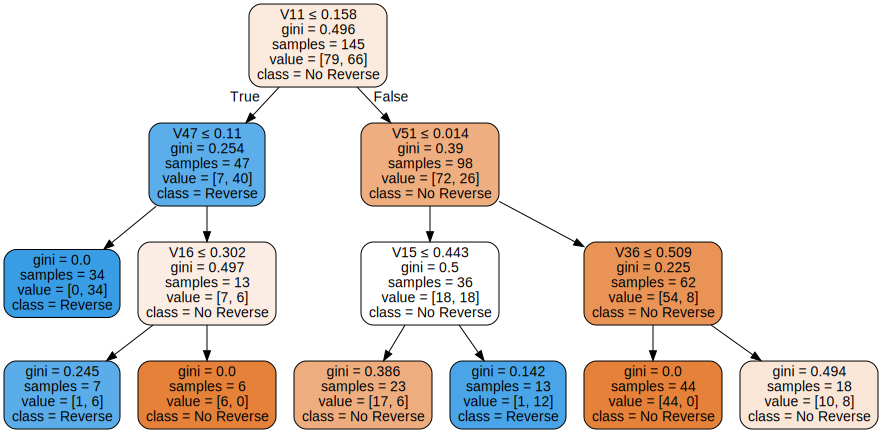

In [10]:
from sklearn import tree as t
import graphviz

dot_data=t.export_graphviz(tree, out_file=None, 
                        feature_names=X_test.columns,  
                        class_names=["No Reverse", "Reverse"],
                        filled=True, rounded=True,  
                        special_characters=True)  
graph=graphviz.Source(dot_data)  
graph 

A continuación vamos a repetir el proceso con *Random Forests*. Usaremos los mismos datos que hemos cargado anteriormente, por lo que no tenemos que volver a cargarlos.

En primer lugar, aprendemos el modelo.

In [11]:
from sklearn.ensemble import RandomForestClassifier

random_forest=RandomForestClassifier(n_estimators=100, random_state=1)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Y, a continuación, validamos con el conjunto de test.

In [12]:
from sklearn.metrics import classification_report

y_pred=random_forest.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted No Reverse', 'Predicted Reverse'],
    index  =['True No Reverse', 'True Reverse']
)
print(conf)

              precision    recall  f1-score   support

           M       0.74      0.88      0.80        32
           R       0.84      0.68      0.75        31

    accuracy                           0.78        63
   macro avg       0.79      0.78      0.77        63
weighted avg       0.79      0.78      0.78        63

                 Predicted No Reverse  Predicted Reverse
True No Reverse                    28                  4
True Reverse                       10                 21


Como se puede observar, los resultados mejoran sensiblemente con *Random Forest*.

### Ejercicio 1.2: Prediciendo la enfermedad de Parkinson a partir de la biometría de la voz

Para nuestro segundo ejercicio con árboles y *Random Forest* vamos a usar un dataset que contiene información de la biometría de la voz de una serie de personas, algunas de ellas diagnosticadas con la enfermedad de **Parkinson**. Se puede encontrar más información sobre el dataset en: https://archive.ics.uci.edu/ml/datasets/parkinsons

Procedemos, como siempre, a cargar nuestros datos.

In [13]:
import pandas as pd

df=pd.read_csv('./data/parkinsons.data')

df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Separamos nuestros datos en los conjuntos de características (X) y etiquetas (y) y eliminamos de paso el identificador *name*.

In [14]:
X=df.drop(['status', 'name'], axis=1)
y=df['status']

Una vez hecho esto, podemos dividir los datos en un conjunto de aprendizaje y otro de validación.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=1)

Procedemos a continuación a preparar nuestro modelo y a hacer el aprendizaje del mismo.

In [16]:
from sklearn.tree import DecisionTreeClassifier

tree=DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Y validamos los resultados obtenidos.

In [17]:
from sklearn.metrics import classification_report

y_pred=tree.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index  =['True Healthy', 'True Parkinsons']
)
print(conf)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39

                 Predicted Healthy  Predicted Parkinsons
True Healthy                     9                     1
True Parkinsons                  2                    27


Como podemos observar, el modelo es capaz de predecir con bastante acierto la enfermedad a partir de la información de la voz.

Por último, podemos pintar el árbol que acabamos de construir.

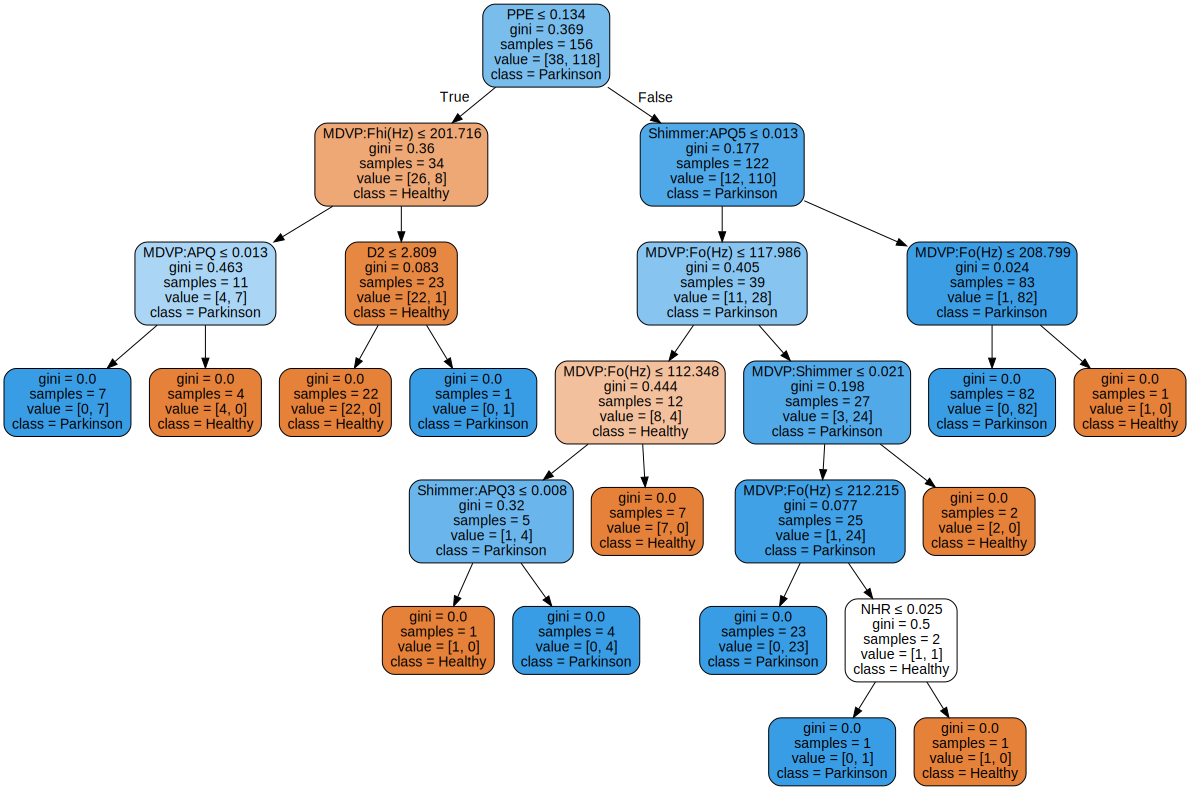

In [18]:
from sklearn import tree as t
import graphviz

dot_data=t.export_graphviz(tree, out_file=None, 
                        feature_names=X.columns,  
                        class_names=["Healthy", "Parkinson"],  
                        filled=True, rounded=True,  
                        special_characters=True)  
graph=graphviz.Source(dot_data)  
graph 

Como vimos antes, *Python* no incorpora post-prunning, por lo que si queremos simplificar el árbol tenemos que hacerlo con las opciones de pre-prunning.

In [19]:
tree=DecisionTreeClassifier(min_samples_split=10, min_samples_leaf=5, max_depth=3)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [20]:
from sklearn.metrics import classification_report

y_true, y_pred = y_test, tree.predict(X_test)

print(classification_report(y_true, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index  =['True Healthy', 'True Parkinsons']
)
print(conf)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.96      0.93      0.95        29

    accuracy                           0.92        39
   macro avg       0.89      0.92      0.90        39
weighted avg       0.93      0.92      0.92        39

                 Predicted Healthy  Predicted Parkinsons
True Healthy                     9                     1
True Parkinsons                  2                    27


Con un modelo más sencillo los resultados son incluso mejores.

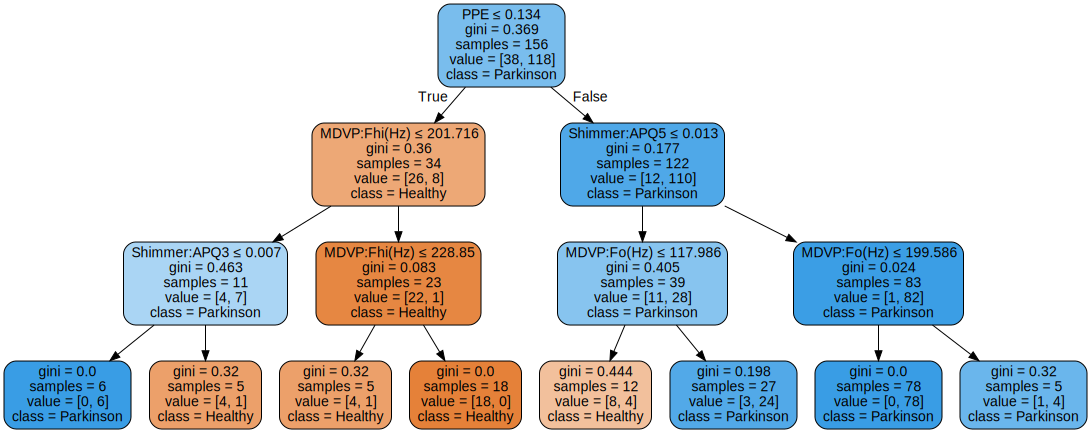

In [21]:
from sklearn import tree as t
import graphviz

dot_data=t.export_graphviz(tree, out_file=None, 
                        feature_names=X.columns,  
                        class_names=["Healthy", "Parkinson"],  
                        filled=True, rounded=True,  
                        special_characters=True)  
graph=graphviz.Source(dot_data)  
graph 

A continuación, podemos probar con un modelo basado en *Random Forests*.

In [22]:
from sklearn.ensemble import RandomForestClassifier

random_forest=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

Obtenemos un rendimiento similar a la configuración de árbol de decisión simplificada.

In [23]:
from sklearn.metrics import classification_report

y_pred=random_forest.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Healthy', 'Predicted Parkinsons'],
    index  =['True Healthy', 'True Parkinsons']
)
print(conf)

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.91      1.00      0.95        29

    accuracy                           0.92        39
   macro avg       0.95      0.85      0.89        39
weighted avg       0.93      0.92      0.92        39

                 Predicted Healthy  Predicted Parkinsons
True Healthy                     7                     3
True Parkinsons                  0                    29


Vamos a probar si somos capaces de ajustar los parámetros del modelo para obtener unos mejores resultados. Para ello, usaremos la función que definimos al principio del programa.

En primer lugar, tenemos que definir la rejilla de parámetros que vamos a explorar.

In [24]:
tuned_parameters={'n_estimators': [1, 10, 30, 50, 100, 150, 200],
                  'max_features': [3, 4, 5],
                  'max_depth'   : [5, 10, 20]}

A continuación, invocamos a la función que definimos antes con los parámetros adecuados.

In [25]:
doGridSearch(RandomForestClassifier(), tuned_parameters, ['accuracy'], X_train, y_train, X_test, y_test, ['Predicted Healthy', 'Predicted Parkinsons'], ['True Healthy', 'True Parkinsons'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_features': 3, 'n_estimators': 200, 'max_depth': 5}

Grid scores on development set:

0.811 (+/-0.245) for {'max_features': 3, 'n_estimators': 1, 'max_depth': 5}
0.859 (+/-0.126) for {'max_features': 3, 'n_estimators': 10, 'max_depth': 5}
0.904 (+/-0.131) for {'max_features': 3, 'n_estimators': 30, 'max_depth': 5}
0.885 (+/-0.147) for {'max_features': 3, 'n_estimators': 50, 'max_depth': 5}
0.897 (+/-0.104) for {'max_features': 3, 'n_estimators': 100, 'max_depth': 5}
0.897 (+/-0.115) for {'max_features': 3, 'n_estimators': 150, 'max_depth': 5}
0.911 (+/-0.128) for {'max_features': 3, 'n_estimators': 200, 'max_depth': 5}
0.820 (+/-0.180) for {'max_features': 4, 'n_estimators': 1, 'max_depth': 5}
0.891 (+/-0.141) for {'max_features': 4, 'n_estimators': 10, 'max_depth': 5}
0.878 (+/-0.130) for {'max_features': 4, 'n_estimators': 30, 'max_depth': 5}
0.890 (+/-0.130) for {'max_features': 4, 'n_estimat

/Volumes/Home/Users/atorre/Workspace/local/packages/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Como podemos ver, esta vez no hemos sido capaces de encontrar una mejor configuración de parámetros de la que encontramos manualmente.

## Ejercicio 2: Naive Bayes

### Ejercicio 2.1: Revisitando el ejercicio de R

Como decíamos al principio, vamos a retomar los ejercicios propuestos en el módulo de R pero, en esta ocasión, los vamos a resolver en *Python*.

El segundo de estos ejemplos era el de predecir el signo político de los congresistas de EEUU a partir de sus votos para 16 leyes del año 1984 (dataset *HouseVotes84*).

Procedemos, como siempre, a cargar nuestros datos. Las variables de los votos son "y" y "n", es decir, binarias. Por tanto, podemos proceder a recodificarlas como variables *dummies*. Antes de hacer esto, sacamos la columna clase, para que no la convierta también, y la volvemos a introducir una vez completado el proceso.

In [26]:
import pandas as pd

df=pd.read_csv('./data/HouseVotes84.csv', na_values="NA")

df_dummies=df.drop("Class", axis=1)
df_dummies=pd.get_dummies(df_dummies)
df_dummies["Class"]=df["Class"]

df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


Dividimos nuestros datos en dos conjuntos independientes.

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df_dummies.drop("Class", axis=1), df_dummies["Class"], test_size=0.3, random_state=1)

Y aprendemos un modelo Naive Bayes a partir de los datos de aprendizaje. Al tratarse de variables binarias, podríamos haber usado un modelo BernoulliNB. Sin embargo, en este caso, el resultado con un modelo gaussiano es un poco mejor.

In [28]:
from sklearn.naive_bayes import GaussianNB

nb=GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Por último, validamos los resultados con el conjunto de validación.

In [29]:
from sklearn.metrics import classification_report

y_pred=nb.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Democrat', 'Predicted Republican'],
    index  =['True Democrat', 'True Republican']
)
print(conf)

              precision    recall  f1-score   support

    democrat       0.97      0.96      0.96        89
  republican       0.91      0.93      0.92        42

    accuracy                           0.95       131
   macro avg       0.94      0.94      0.94       131
weighted avg       0.95      0.95      0.95       131

                 Predicted Democrat  Predicted Republican
True Democrat                    85                     4
True Republican                   3                    39


De nuevo, observamos cómo el modelo es capaz de dar una muy buena predicción del partido político a partir de las votaciones.

### Ejercicio 2.2: Gaussian Naive Bayes

Vamos a abordar un nuevo problema que resolveremos con Naive Bayes. En este caso, se trata de un *dataset* con información sobre vinos. A partir de esta información, queremos ser capaces de predecir la clase de vino (en una escala del 1 al 3) a la que pertence cada uno de ellos.

Lo primero de todo es, como siempre, cargar los datos. En esta ocasión, como las columnas no están etiquetadas en el fichero, aprovechamos el proceso de cargado para darles nombre. También nos aseguramos de convertir el atributo de clase en una variable categórica (podríamos haberlo hecho también al cargar los datos, pero hemos preferido hacerlo a posteriori para ilustrar cómo se haría).

In [30]:
import pandas as pd

df = pd.read_csv('./data/wine.data', names=["Class", "Alcohol", "Malic", "Ash", "Alcalinity", "Magnesium", "Phenols", "Flavanoids", "Nonflavanoid", "Proanthocyanins", "Color", "Hue", "OD280_OD315", "Proline"])

df["Class"]=df["Class"].astype('category')

df.head()

,Class,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280_OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Llevamos a cabo el particionado de los datos como acostumbramos a hacer.

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop("Class", axis=1), df["Class"], test_size=0.3, random_state=1)

Y aprendemos el modelo con los datos de aprendizaje.

In [32]:
from sklearn.naive_bayes import GaussianNB

nb=GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

Por último, procedemos a realizar la validación.

In [33]:
from sklearn.metrics import classification_report

y_pred=nb.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Predicted Class 1', 'Predicted Class 2', 'Predicted Class 3'],
    index  =['True Class 1', 'True Class 2', 'True Class 3']
)
print(conf)

              precision    recall  f1-score   support

           1       0.96      1.00      0.98        23
           2       1.00      0.95      0.97        19
           3       1.00      1.00      1.00        12

    accuracy                           0.98        54
   macro avg       0.99      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54

              Predicted Class 1  Predicted Class 2  Predicted Class 3
True Class 1                 23                  0                  0
True Class 2                  1                 18                  0
True Class 3                  0                  0                 12


Y observamos cómo somos capaces de predecir cada clase casi a la perfección.

### Ejercicio 2.3: Multinomial Naive Bayes

En este último ejemplo de Naive Bayes vamos a trabajar con datos no estructurados. En este caso, vamos a trabajar con un *dataset* consistente en conjunto de mensajes provenientes de un foro de noticias. Cada mensaje está etiquetado de acuerdo a la temática a la que pertenece (de entre unas cuantas seleccionadas).

Para cargar este dataset, basta con que lo hagamos desde el conjunto de *datasets* que proporciona *scikit-learn* por defecto haciendo un *import* del mismo y luego invocando a la función *fetch* adecuada.

In [34]:
from sklearn.datasets import fetch_20newsgroups

data=fetch_20newsgroups()

Podemos ver las temáticas en las que se han categorizado los mensajes imprimiendo *"target_names"*.

In [35]:
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Como podemos observar, hay algunos temas que tienen un potencial posible solapamiento que veremos más adelante. En este caso, vamos a aprender el modelo con todos los datos. Sin embargo, si quisiéramos trabajar sobre un subconjunto, sería tan sencillo como seleccionar una lista de categorías y usarlas al llamar a *fetch*.

In [36]:
#categories=['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics']

#train=fetch_20newsgroups(subset='train', categories=categories)
#test =fetch_20newsgroups(subset='test' , categories=categories)

train=fetch_20newsgroups(subset='train')
test =fetch_20newsgroups(subset='test' )

Una vez recuperados los datos, podemos examinar el contenido de alguno de los mensajes para ver qué forma tienen.

In [37]:
print(train.data[5])

From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)
Subject: Re: Rewording the Second Amendment (ideas)
Organization: VTT
Lines: 58

In article <1r1eu1$4t@transfer.stratus.com> cdt@sw.stratus.com (C. D. Tavares) writes:
>In article <1993Apr20.083057.16899@ousrvr.oulu.fi>, dfo@vttoulu.tko.vtt.fi (Foxvog Douglas) writes:
>> In article <1qv87v$4j3@transfer.stratus.com> cdt@sw.stratus.com (C. D. Tavares) writes:
>> >In article <C5n3GI.F8F@ulowell.ulowell.edu>, jrutledg@cs.ulowell.edu (John Lawrence Rutledge) writes:
>
>> >> The massive destructive power of many modern weapons, makes the
>> >> cost of an accidental or crimial usage of these weapons to great.
>> >> The weapons of mass destruction need to be in the control of
>> >> the government only.  Individual access would result in the
>> >> needless deaths of millions.  This makes the right of the people
>> >> to keep and bear many modern weapons non-existant.

>> >Thanks for stating where you're coming from.  Needless to say, I
>> >disagree 

Trabajar directamente sobre los datos es muy complicado, por lo que normalmente se utilizan codificaciones intermedias que representen la información contenida en los mensajes de manera indirecta. Una de estas codificaciones es la **term frequency–inverse document frequency** (TF-IDF) que calcula la frecuencia de cada palabra del *corpus* en los mensajes y luego deriva un estadístico que otorga más importancia a aquellos términos más frecuentes.

Para más información sobre esta codificación, se puede consultar: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

En nuestro caso, para hacer el proceso aún más sencillo, vamos a definir un *pipeline* que aplique la transformación sobre los datos como una etapa previa al aprendizaje del propio modelo. Además, usaremos un modelo Multinomial de Naive Bayes, que suele ser más adecuado en estos casos.

In [38]:
from sklearn.naive_bayes             import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline                import make_pipeline

multnb=make_pipeline(TfidfVectorizer(), MultinomialNB())

Una vez definido el *pipeline*, podemos trabajar sobre él como sobre cualquier otro modelo, haciendo primero el aprendizaje...

In [39]:
multnb.fit(train.data, train.target)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

... y luego la predicción...

In [40]:
from sklearn.metrics import classification_report

y_pred=multnb.predict(test.data)

print(classification_report(test.target, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.52      0.63       319
           1       0.81      0.65      0.72       389
           2       0.82      0.65      0.73       394
           3       0.67      0.78      0.72       392
           4       0.86      0.77      0.81       385
           5       0.89      0.75      0.82       395
           6       0.93      0.69      0.80       390
           7       0.85      0.92      0.88       396
           8       0.94      0.93      0.93       398
           9       0.92      0.90      0.91       397
          10       0.89      0.97      0.93       399
          11       0.59      0.97      0.74       396
          12       0.84      0.60      0.70       393
          13       0.92      0.74      0.82       396
          14       0.84      0.89      0.87       394
          15       0.44      0.98      0.61       398
          16       0.64      0.94      0.76       364
          17       0.93    

Como el número de clases es bastante elevado, podemos aprovechar para representar la matriz de confusión como un *heatmap* que es más fácil de recorrer visualmente.

Vamos a utilizar la biblioteca *seaborn*, que debemos inicializar llamando a *set()* antes de hacer nada más.

A continuación, calculamos la matriz de confusión como habitualmente y guardamos el resultado. Definimos el tamaño del gráfico, y lo pintamos como un *heatmap*. Con las opciones que nos proporciona podemos manipular el estilo y la anotaciones que queremos que aparezcan en cada celda. También podemos deshabilitar la barra lateral y especificar las etiquetas de los ejes.

Text(93.09312500000001, 0.5, 'Predicted label')

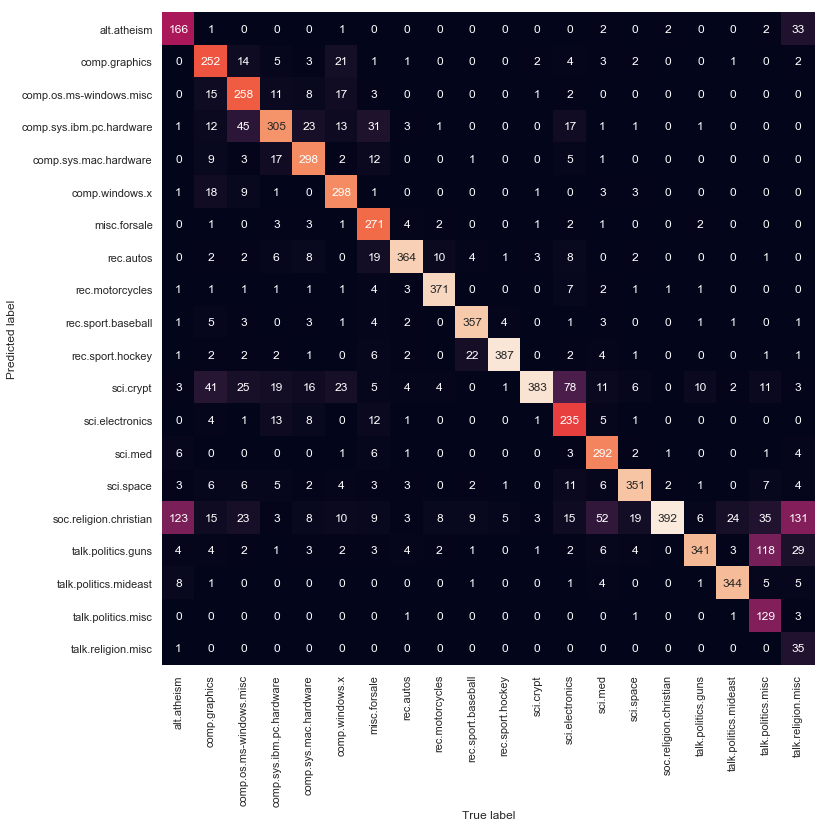

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns; sns.set()

from sklearn.metrics import confusion_matrix
mat=confusion_matrix(test.target, y_pred)

fig, ax=plt.subplots(figsize=(12,12))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names, ax=ax)

plt.xlabel('True label')
plt.ylabel('Predicted label')

Como era de esperar, existe cierto solapamiento, especialmente entre subcategorías dentro de una categoría (como religión cristiana y ateísmo, por ejemplo).

Si queremos usar el modelo para hacer predicciones sobre nuevos mensajes, podemos usarlo a través de una función auxiliar que reciba la nueva cadena y el modelo.

In [42]:
def predict_category(s, train=train, model=multnb):
    pred=model.predict([s])
    return train.target_names[pred[0]]

Podemos ponerlo a prueba con una serie de frases...

In [43]:
predict_category('George W. Bush was the worst president in history')

'talk.politics.mideast'

In [44]:
predict_category('And he was friend with Saddam Hussein')

'talk.politics.mideast'

In [45]:
predict_category('On the other hand, God does not exist')

'soc.religion.christian'

In [46]:
predict_category('But I have to hurry becasuse I am feeling pain in my stomach')

'sci.med'

In [47]:
predict_category('BTW Macs are much better than PCs')

'comp.sys.mac.hardware'

Como podemos observar, las predicciones son razonablemente precisas.

## Ejercicio 3: k-NN

### Ejercicio 3.1: Revisitando el ejercicio de R

Como decíamos al principio, vamos a retomar los ejercicios propuestos en el módulo de R pero, en esta ocasión, los vamos a resolver en *Python*.

El tercero de estos ejemplos era el de predecir el tipo de tumor (benigno o maligno) encontrado en el pecho a partir de una serie de características morforlógicas de la masa identificada.

Procedemos, como siempre, a cargar nuestros datos.

In [48]:
import pandas as pd

df = pd.read_csv('./data/cancer.csv')

df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst,class
0,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,0.686364,0.605518,...,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864,malignant
1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,0.379798,0.141323,...,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878,malignant
2,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,0.509596,0.211247,...,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433,malignant
3,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,0.776263,1.000000,...,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711,malignant
4,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,0.378283,0.186816,...,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595,malignant


Dividimos, como siempre, nuestros datos en un conjunto de aprendizaje y otro de validación.

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df.drop("class", axis=1), df["class"], test_size=0.3, random_state=1)

Entrenamos un modelo con 3 vecinos.

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Y hacemos la validación con los datos no vistos hasta este momento.

In [51]:
from sklearn.metrics import classification_report

y_pred=knn.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted Benign', 'Predicted Malignant'],
    index  =['True Benign', 'True Malignant']
)
print(conf)

              precision    recall  f1-score   support

      benign       0.95      0.98      0.96       108
   malignant       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

                Precicted Benign  Predicted Malignant
True Benign                  106                    2
True Malignant                 6                   57


Los resultados obtenidos son, como en el caso de R, muy buenos.

Es de reseñar que, aunque en el caso de kNN el modelo no se aprende como tal, si no que se hacen las predicciones a partir de las distancias con respecto a los datos de entrenamiento, la interfaz de *scikit-learn* es la misma que para el resto de algoritmos de clasificación, por motivos de uniformidad.

### Ejercicio 3.2: k-NN para reconstrucción de imagen

En este nuevo ejemplo con kNN vamos a tratar de usar el algoritmo para reconstruir una imagen a la que le quitamos un número importante de píxeles.

Para definir la imagen lo que haremos será definir un *data frame* con la información de los píxeles (coordenadas x e y) y el color de cada uno de estos píxeles.

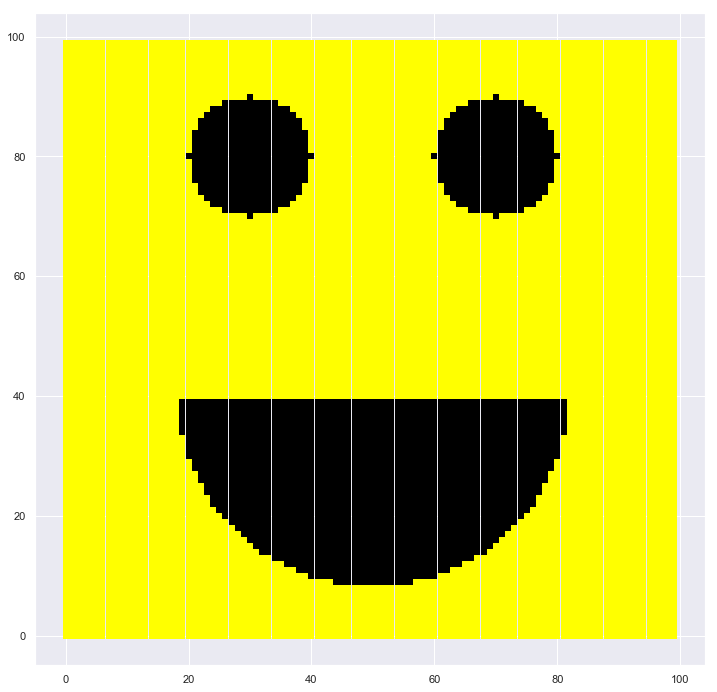

In [52]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

data = []
for i in range(0, 100):
    for j in range(0, 100):
        data.append([i, j])

df = pd.DataFrame(data, columns=['x', 'y'])
df['color'] = 'yellow'

# left eye
idx = ((df['x'] - 30)**2 + (df['y'] - 80)**2 <= 100)
df['color'] = np.where(idx, 'black', 'yellow')

# right eye
idx = ((df['x'] - 70)**2 + (df['y'] - 80)**2 <= 100)
df['color'] = np.where(df['color']!='black', np.where(idx, 'black', 'yellow'), df['color'])

# smile
idx = ((df['x'] - 50)**2 + (df['y'] - 40)**2 <= 1000)
idx = idx & (df['y'] < 40)

df['color'] = np.where(df['color']!='black', np.where(idx, 'black', 'yellow'), df['color'])

fig, ax = plt.subplots(figsize=(12,12)) 

for color in ['yellow', 'black']:
    plt.scatter(df[df.color==color].x, df[df.color==color].y, c=color, marker=',', edgecolors='none')

plt.show()

Comenzaremos dividiendo el conjunto de datos en un subconjunto de aprendizaje y uno de validación. La división la haremos al 50%, lo cual supondrá que perderemos la mitad de la información en píxeles para hacer el aprendizaje del modelo.

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df.drop("color", axis=1), df["color"], test_size=0.50, random_state=1)

Podemos pintar los píxeles restantes en el conjunto de aprendizaje para comprobar la severidad de la pérdida.

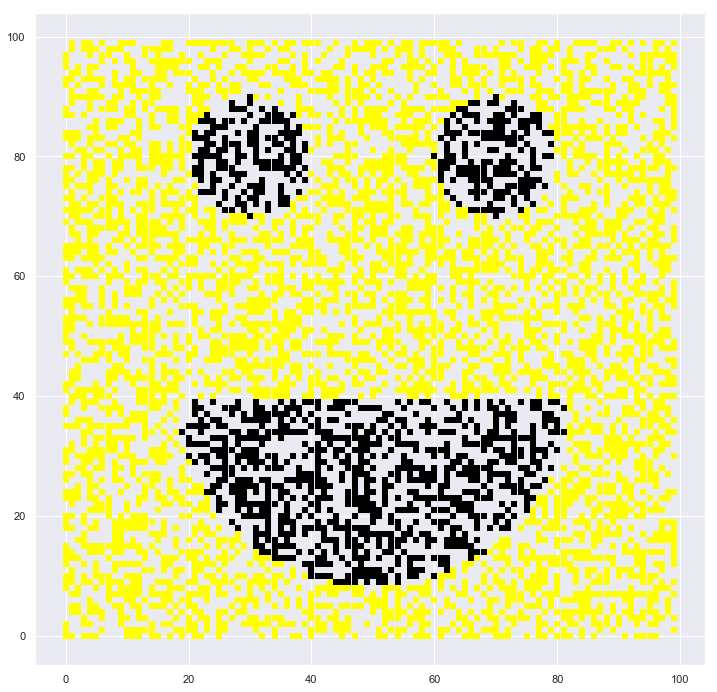

In [54]:
fig, ax=plt.subplots(figsize=(12,12)) 

for color in ['yellow', 'black']:
    plt.scatter(X_train[y_train==color].x, X_train[y_train==color].y, c=color, marker=',', edgecolors='none')

plt.show()

Como podemos observar, a la imagen le falta una gran cantidad de información.

Procedemos a continuación a entrenar un modelo con la información de que disponemos.

In [55]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

Y lo usamos para predecir la información de los píxeles restantes.

In [56]:
from sklearn.metrics import classification_report

y_pred=knn.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted Black', 'Predicted Yellow'],
    index  =['True Black', 'True Yellow']
)
print(conf)

              precision    recall  f1-score   support

       black       0.99      0.97      0.98      1111
      yellow       0.99      1.00      0.99      3889

    accuracy                           0.99      5000
   macro avg       0.99      0.98      0.99      5000
weighted avg       0.99      0.99      0.99      5000

             Precicted Black  Predicted Yellow
True Black              1073                38
True Yellow               11              3878


El modelo es muy bueno prediciendo el color de los píxeles que faltan.

Podemos rellenar los huecos con las etiquetas predichas y observaremos cómo el resultado es muy parecido al original.

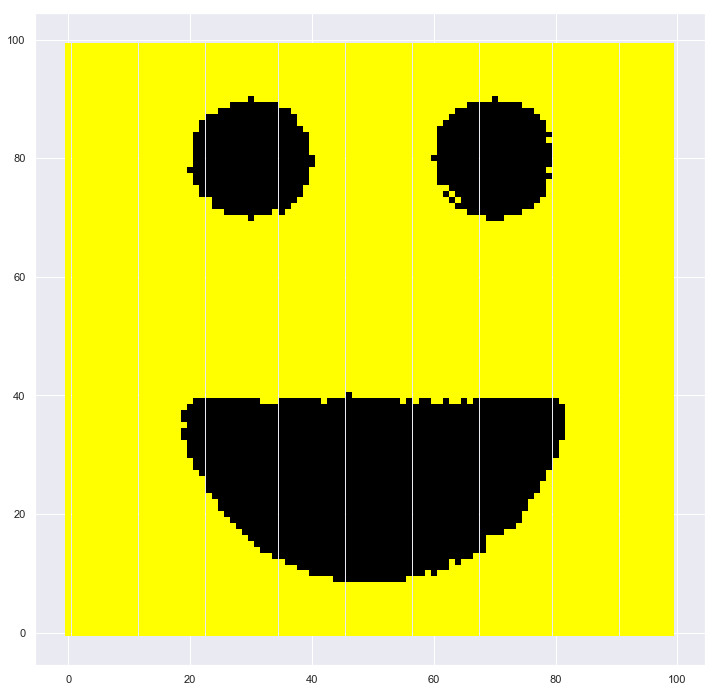

In [57]:
fig, ax=plt.subplots(figsize=(12,12)) 

for color in ['yellow', 'black']:
    plt.scatter(X_train[y_train==color].x, X_train[y_train==color].y, c=color, marker=',', edgecolors='none')

for color in ['yellow', 'black']:
    plt.scatter(X_test[y_pred==color].x, X_test[y_pred==color].y, c=color, marker=',', edgecolors='none')

plt.show()

## Ejercicio 4: SVMs

### Ejercicio 4.1: Revisitando el ejercicio de R

Como decíamos al principio, vamos a retomar los ejercicios propuestos en el módulo de R pero, en esta ocasión, los vamos a resolver en *Python*.

El cuarto de estos ejemplos era el de predecir el tipo de correo (*spam* o legítimo) a partir de una serie de características extraídas del texto de los correos.

Procedemos, como siempre, a cargar nuestros datos.

In [58]:
import pandas as pd

df = pd.read_csv('./data/spam.csv')

df.head()

,A.1,A.2,A.3,A.4,A.5,A.6,A.7,A.8,A.9,A.10,...,A.49,A.50,A.51,A.52,A.53,A.54,A.55,A.56,A.57,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,spam
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam


Como podemos observar en estas primeras instancias del dataset, algunas variables están en rangos de valores muy diferentes (las primeras son porcentajes, mientras que las últimas se mueven, en algunos casos, en el orden de los miles). Para que el algoritmo SVM funcione correctamente, necesitaremos que todas las variables se muevan en el mismo orden de magnitud. Si no, estaríamos añadiendo una ponderación errónea a algunas de las variables.

Por todo lo anterior, procedemos a reescalar nuestros datos, usando el objeto MinMaxScaler de scikit-learn.

In [59]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
df_scaled=scaler.fit_transform(df.drop("spam", axis=1))

Una vez escalados los datos, los dividimos en un conjunto de aprendizaje y otro de validación.

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df_scaled, df["spam"], test_size=0.30, random_state=1)

Procedemos a aprender el modelo.

In [61]:
from sklearn.svm import SVC

svc=SVC(kernel='rbf', gamma='scale')
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Y lo validamos con los datos no vistos hasta este momento.

In [62]:
from sklearn.metrics import classification_report

y_pred=svc.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted E-mail', 'Predicted Spam'],
    index  =['True E-mail', 'True Spam']
)
print(conf)

              precision    recall  f1-score   support

       email       0.92      0.97      0.95       841
        spam       0.94      0.88      0.91       540

    accuracy                           0.93      1381
   macro avg       0.93      0.92      0.93      1381
weighted avg       0.93      0.93      0.93      1381

             Precicted E-mail  Predicted Spam
True E-mail               813              28
True Spam                  66             474


### Ejercicio 4.2: reconocimiento facial

Para este nuevo ejemplo de SVM vamos a tratar con un conjunto de datos de fotos de personajes famosos. Es un *dataset* que se distribuye junto con *scikit_learn*, por lo que podemos descargarlo de una manera similar al caso de los mensajes que vimos anteriormente.

Para mejorar la capacidad predictiva del modelo, nos vamos a centrar únicamente en aquellas personas con más de 60 imágenes en la base de datos.

In [63]:
from sklearn.datasets import fetch_lfw_people

faces=fetch_lfw_people(min_faces_per_person=60)

Podemos consultar los nombres de los personajes seleccionados.

In [64]:
print(faces.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


Y también podemos visualizar una muestra de dichas imágenes para ver qué pinta tienen.

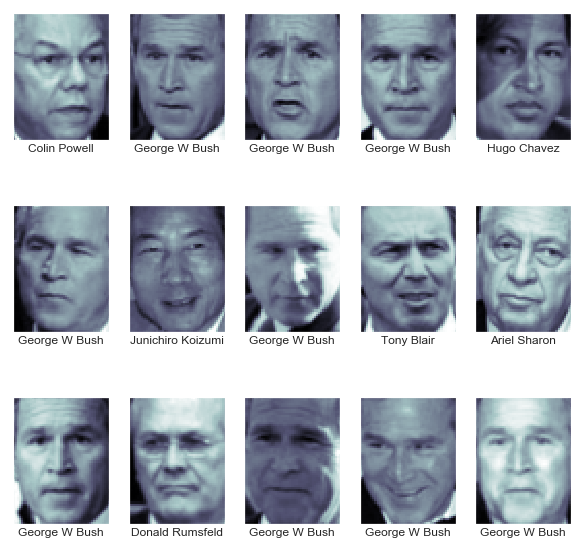

In [65]:
fig, ax=plt.subplots(3, 5, figsize=(10,10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Lógicamente, el algoritmo no va a trabajar directamente con las imágenes, sino que las va a tratar como matrices numéricas. Además, para reducir el tamaño de los datos de entrada, vamos a hacer una proyección en componentes principales y nos vamos a quedar con las 150 primeras. En espacios de tantas dimensiones, *Randomized PCA* funciona mejor que un PCA clásico.

Del mismo modo que en casos anteriores, procedemos a aplicar el pre-procesado y el modelo como un único *pipeline*.

In [66]:
from sklearn.svm           import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline      import make_pipeline

pca=PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=1)
svc=SVC(kernel='rbf', class_weight='balanced')
model=make_pipeline(pca, svc)

Una vez construido el *pipeline*, podemos dividir nuestros datos en conjunto de aprendizaje y validación.

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(faces.data, faces.target, random_state=1)

Como no tenemos una idea clara de la configuración de parámetros apropiada para este problema, vamos a hacer un ajuste de  parámetros similar al que hicimos en anteriores ejercicios.

En primer lugar, definimos la rejilla de parámetros que se deben explorar.

In [68]:
tuned_parameters = {'svc__C'    : [1, 5, 10, 50],
                    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

A continuación, invocamos a la función de búsqueda con los parámetros adecuados.

In [69]:
best=doGridSearch(model, tuned_parameters, ['accuracy'], X_train, y_train, X_test, y_test, list(faces.target_names), list(faces.target_names))

# Tuning hyper-parameters for accuracy



/Volumes/Home/Users/atorre/Workspace/local/packages/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best parameters set found on development set:

{'svc__C': 1, 'svc__gamma': 0.005}

Grid scores on development set:

0.130 (+/-0.105) for {'svc__C': 1, 'svc__gamma': 0.0001}
0.607 (+/-0.094) for {'svc__C': 1, 'svc__gamma': 0.0005}
0.815 (+/-0.090) for {'svc__C': 1, 'svc__gamma': 0.001}
0.843 (+/-0.077) for {'svc__C': 1, 'svc__gamma': 0.005}
0.742 (+/-0.124) for {'svc__C': 5, 'svc__gamma': 0.0001}
0.830 (+/-0.083) for {'svc__C': 5, 'svc__gamma': 0.0005}
0.830 (+/-0.072) for {'svc__C': 5, 'svc__gamma': 0.001}
0.836 (+/-0.077) for {'svc__C': 5, 'svc__gamma': 0.005}
0.816 (+/-0.084) for {'svc__C': 10, 'svc__gamma': 0.0001}
0.822 (+/-0.066) for {'svc__C': 10, 'svc__gamma': 0.0005}
0.835 (+/-0.067) for {'svc__C': 10, 'svc__gamma': 0.001}
0.836 (+/-0.081) for {'svc__C': 10, 'svc__gamma': 0.005}
0.808 (+/-0.075) for {'svc__C': 50, 'svc__gamma': 0.0001}
0.816 (+/-0.059) for {'svc__C': 50, 'svc__gamma': 0.0005}
0.824 (+/-0.052) for {'svc__C': 50, 'svc__gamma': 0.001}
0.836 (+/-0.081) for {'svc__C

Podemos usar el mejor predictor devuelto para predecir sobre el conjunto de test y visualizar los resultados gráficamente.

In [70]:
y_pred=best.predict(X_test)

Tomando las predicciones, representamos algunas de las imágenes y resaltamos el nombre de la persona en rojo en caso de que haya algún error.

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

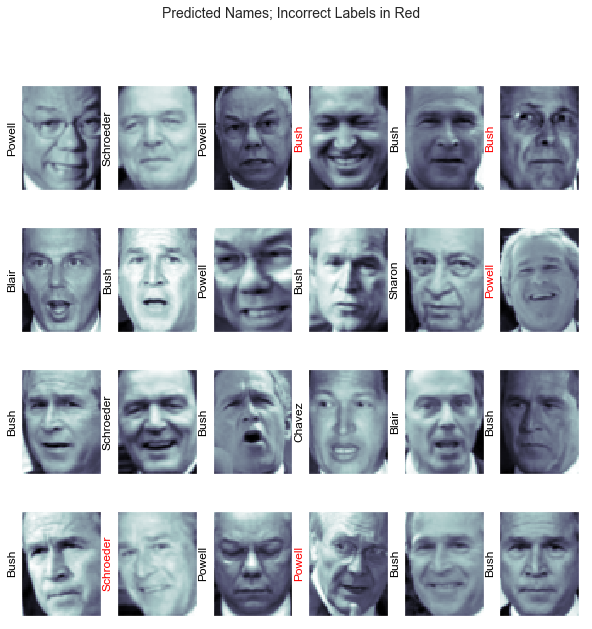

In [71]:
fig, ax=plt.subplots(4, 6, figsize=(10,10))

for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y_test[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

Por último, podemos visualizar la información de la matriz de confusión gráficamente, para una mejor interpretación.

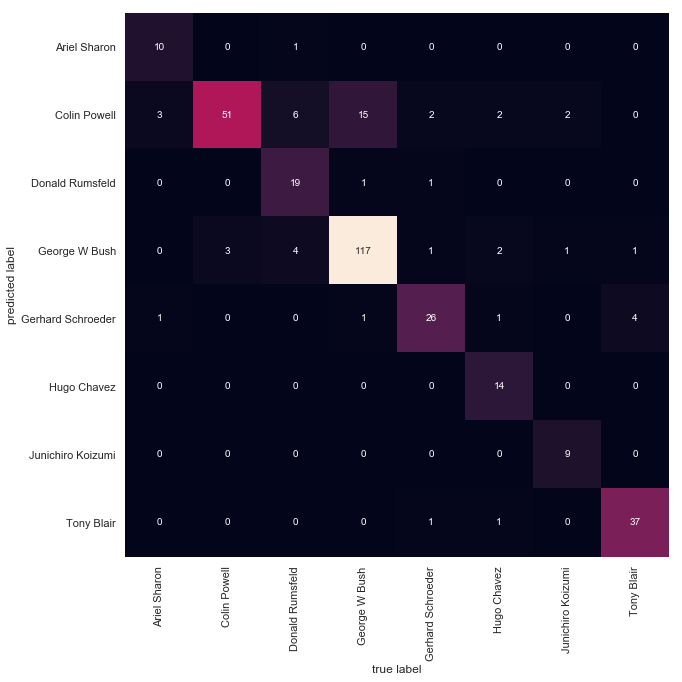

In [72]:
from sklearn.metrics import confusion_matrix

fig, ax=plt.subplots(figsize=(10,10))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names, ax=ax)
plt.xlabel('true label')
plt.ylabel('predicted label');

En esta representación podemos observar que la mayor fuente de error es Colin Powell, que es confundido en muchas ocasiones con George W. Bush.

## Ejercicio 5: Redes de neuronas

### Ejercicio 5.1: Revisitando el ejercicio de R

Como decíamos al principio, vamos a retomar los ejercicios propuestos en el módulo de R pero, en esta ocasión, los vamos a resolver en *Python*.

El quinto de estos ejemplos era el de predecir si un cliente iba a dar *default* en 10 años a partir de su información crediticia, de ingresos, etc.

Procedemos, como siempre, a cargar nuestros datos.

In [73]:
import pandas as pd

df=pd.read_csv('./data/creditset.csv')

df.drop("clientid", axis=1, inplace=True)

df.head()

,income,age,loan,LTI,default10yr
0,66155.925095,59.017015,8106.532131,0.122537,0
1,34415.153966,48.117153,6564.745018,0.190752,0
2,57317.170063,63.108049,8020.953296,0.139940,0
3,42709.534201,45.751972,6103.642260,0.142911,0
4,66952.688845,18.584336,8770.099235,0.130989,1


Procedemos, como siempre, a partir nuestro conjunto de datos en un subconjunto de aprendizaje y otro de validación.

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(df.drop("default10yr", axis=1), df["default10yr"], random_state=1)

Una vez hecho esto, podemos configurar una red de neuronas similar a la que teníamos entonces.

In [75]:
from sklearn.neural_network import MLPClassifier

# Alpha es el parámetro de regularización (fuerza a que hayan neuronas con pesos despreciables)

mlp=MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(4, 1), random_state=1, verbose=True)

Y aprender el modelo, usando todas las variables.

In [76]:
mlp.fit(X_train, y_train)

Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = inf
Iteration 21, loss = inf
Iteration 22, loss = inf
Iteration 23, loss = inf
Iteration 24, loss = inf
Iteration 25, loss = inf
Iteration 26, loss = inf
Iteration 27, loss = inf
Iteration 28, loss = inf
Iteration 29, loss = inf
Iteration 30, loss = inf
Iteration 31, loss = inf
Iteration 32, loss = inf
Iteration 33, loss = inf
Iteration 34, loss = inf
Iteration 35, loss = inf
Iteration 36, loss = inf
Iteration 37, loss = inf
Iteration 38, loss = inf
Iteration 39, loss = inf
Iteration 40, loss = inf
Iteration

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(4, 1), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

Como podemos observar, de nuevo, con todas las variables el modelo no converge a una solución buena.

In [77]:
from sklearn.metrics import classification_report

y_pred=mlp.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted No Default', 'Predicted Default'],
    index  =['True No Default'     , 'True Default'     ]
)
print(conf)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       417
           1       0.00      0.00      0.00        83

    accuracy                           0.83       500
   macro avg       0.42      0.50      0.45       500
weighted avg       0.70      0.83      0.76       500

                 Precicted No Default  Predicted Default
True No Default                   417                  0
True Default                       83                  0


/Volumes/Home/Users/atorre/Workspace/local/packages/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Si ahora seleccionamos las dos variables que habíamos identificado como más informativas, vemos cómo el modelo mejora significativamente.

In [78]:
mlp=MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10,  1), random_state=1, verbose=True, activation="relu", max_iter=1000)

mlp.fit(X_train.drop(["loan", "income"], axis=1), y_train)

Iteration 1, loss = 0.48989078
Iteration 2, loss = 0.48228788
Iteration 3, loss = 0.48119122
Iteration 4, loss = 0.47982014
Iteration 5, loss = 0.47837754
Iteration 6, loss = 0.47684377
Iteration 7, loss = 0.47515968
Iteration 8, loss = 0.47361743
Iteration 9, loss = 0.47203018
Iteration 10, loss = 0.47061947
Iteration 11, loss = 0.46919841
Iteration 12, loss = 0.46771706
Iteration 13, loss = 0.46629578
Iteration 14, loss = 0.46496051
Iteration 15, loss = 0.46354562
Iteration 16, loss = 0.46225507
Iteration 17, loss = 0.46085902
Iteration 18, loss = 0.45952515
Iteration 19, loss = 0.45828068
Iteration 20, loss = 0.45693732
Iteration 21, loss = 0.45579448
Iteration 22, loss = 0.45449277
Iteration 23, loss = 0.45317657
Iteration 24, loss = 0.45194108
Iteration 25, loss = 0.45071873
Iteration 26, loss = 0.44949692
Iteration 27, loss = 0.44832475
Iteration 28, loss = 0.44713700
Iteration 29, loss = 0.44596432
Iteration 30, loss = 0.44484525
Iteration 31, loss = 0.44366461
Iteration 32, los

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 1), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

In [79]:
from sklearn.metrics import classification_report

y_pred=mlp.predict(X_test.drop(["loan", "income"], axis=1))

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted No Default', 'Predicted Default'],
    index  =['True No Default'     , 'True Default'     ]
)
print(conf)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       417
           1       0.86      0.67      0.76        83

    accuracy                           0.93       500
   macro avg       0.90      0.83      0.86       500
weighted avg       0.93      0.93      0.92       500

                 Precicted No Default  Predicted Default
True No Default                   408                  9
True Default                       27                 56


Si, además, añadimos un preprocesado que normalice las variables, los resultados son aún mejores.

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import make_pipeline

norm =StandardScaler()
mlp  =MLPClassifier(alpha=1e-5, hidden_layer_sizes=(10,  1), random_state=1, verbose=True, activation="relu", max_iter=1000)
model=make_pipeline(norm, mlp)

model.fit(X_train.drop(["loan", "income"], axis=1), y_train)

Iteration 1, loss = 0.71125422
Iteration 2, loss = 0.68562129
Iteration 3, loss = 0.66189337
Iteration 4, loss = 0.63958354
Iteration 5, loss = 0.61933217
Iteration 6, loss = 0.59977326
Iteration 7, loss = 0.58220057
Iteration 8, loss = 0.56570694
Iteration 9, loss = 0.55026652
Iteration 10, loss = 0.53573485
Iteration 11, loss = 0.52218959
Iteration 12, loss = 0.50917893
Iteration 13, loss = 0.49726198
Iteration 14, loss = 0.48669881
Iteration 15, loss = 0.47806620
Iteration 16, loss = 0.47198144
Iteration 17, loss = 0.46834490
Iteration 18, loss = 0.46619146
Iteration 19, loss = 0.46461352
Iteration 20, loss = 0.46322867
Iteration 21, loss = 0.46195712
Iteration 22, loss = 0.46063567
Iteration 23, loss = 0.45924524
Iteration 24, loss = 0.45752568
Iteration 25, loss = 0.45444991
Iteration 26, loss = 0.45067228
Iteration 27, loss = 0.44689575
Iteration 28, loss = 0.44341012
Iteration 29, loss = 0.44005199
Iteration 30, loss = 0.43672482
Iteration 31, loss = 0.43352623
Iteration 32, los

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('mlpclassifier',
                 MLPClassifier(activation='relu', alpha=1e-05,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(10, 1),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=1, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=True, warm_start=False))],
         verbose=False)

In [81]:
from sklearn.metrics import classification_report

y_pred=model.predict(X_test.drop(["loan", "income"], axis=1))

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted No Default', 'Predicted Default'],
    index  =['True No Default'     , 'True Default'     ]
)
print(conf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       0.99      1.00      0.99        83

    accuracy                           1.00       500
   macro avg       0.99      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

                 Precicted No Default  Predicted Default
True No Default                   416                  1
True Default                        0                 83


### Ejercicio 5.2: Revisitando el ejercicio de MXNET y MNIST

El segundo ejercicio que hicimos en R tuvo que ver con el uso de la biblioteca MXNET para aprender una red convolucional que permitiera clasificar dígitos manuscritos.

En el caso de *Python*, este *dataset* forma parte de la distribuición del paquete *scikit-learn*, por lo que podemos cargarlo directamente desde el paquete de datos. Igual que en el caso de R, procedemos a normalizar los datos dividiendo por 255. Además, prepararemos los arrays con la información para la primera prueba que haremos, que será con redes densamente conectadas, por lo que tendremos que tener toda la información en un *array*.

Ver que usamos un reshape. Esto es porque las 60.000 imagenes en train y 10.000 en test son una matriz de 24 x 24 = 728. Lo que hago con el reshape es básicamente aplanarlo y convertir la información de 70.000 matrices de 2 dimensiones en, 70.000 vectores de largo 728.

In [6]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

In [1]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test)=mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test  = X_test.reshape (10000, 784)

X_train = X_train.astype ('float32' )
X_test  = X_test.astype  ('float32' )

X_train/= 255
X_test /= 255

11493376/11490434 [==============================] - 1s 0us/step


Una vez tenemos los datos cargados, podemos proceder a definir y entrenar el modelo. En concreto, tenemos que conectar la entrada (que tiene dimensión 784=28\*28 píxeles) con sendas capas densas (de 128 y 64 neuronas) y con la capa de salida (en la que aplicamos *softmax*).

Además, para que la validación pueda hacerse correctamente, hay que convertir las etiquetas, que vienen como un *array* de números en matrices binarias, donde cada fila contendrá un 1 en la posición correspondiente al número en cuestión y 0s en el resto de columnas.

Una vez listo el modelo, podemos "compilarlo" especificando la medidas de coste y calidad y el optimzizador que se usará.

Para terminar, lo entrenamos y usamos el método *evaluate* que proporciona *keras* para validar con el conjunto de validación.

In [2]:
import keras

from keras.models import Sequential
from keras.layers import Dense

num_classes=10

# convert class vectors to binary class matrices
y_train_cat=keras.utils.to_categorical(y_train, num_classes)
y_test_cat =keras.utils.to_categorical(y_test , num_classes)

model=Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,))) 
# Con input_shape le estoy diciendo implícitamente que hay una capa de entrada de 784 neuronas (784 píxeles). Si no hago esto tengo que crear una capa
# más para tener en cuenta las variables de entrada.

model.add(Dense(64 , activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
# La función de activación 'softmax' es como la sigmoide pero para un porblema de clasificación de múltiples clases. Me asegura que todas las salidas
# para cada clase estén entre 0 y 1, y que sumadas sumen 1.

model.summary() 
# Esto hace un resumen de los parámetros que voy a generar por cada capa (cuenta el bias). Por ejemplo, la capa 0 tiene 784 + 1 neuronas (los features)
# más el bias. Y la capa 1 tiene 128 neuronas, entonces voy a tener 785 * 128 = 100480 parámetros para dijar en esa iteración.

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train_cat, epochs=3, verbose=1, validation_data=(X_test, y_test_cat))

score=model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:'    , score[0])
print('Test accuracy:', score[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1875/1875 [==============================] - 1s 747us/step - loss: 0.2418 - accuracy: 0.9291 - val_loss: 0.1208 - val_accuracy: 0.9626
Epoch 2/3
1875/1875 [==============================] - 1s 696us/step - loss: 0.1024 - accuracy: 0.9686 - val_loss: 0.0918 - val_accuracy: 0.9725
Epoch 3/3
1875/1875 [==============================] - 1s 642us/step - loss: 0.0724 - accu

Como podemos observar, los resultados son bastante buenos (mejores que en el caso de MXNET).

Podemos visualizar la matriz de confusión para tener el detalle de la distribución del error en las distintas clases.

In [7]:
from sklearn.metrics import classification_report

y_pred=model.predict_classes(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
)
print(conf)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.95      0.98      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

     0     1     2    3    4    5    6    7    8    9
0  967     0     1    0    2    1    2    2    3    2
1    0  1114     7    2    0    0    4    1    6    1
2    5     0  1010    3    0    0    1    4    8    1
3    0     0     9  976  

A continuación, pasaremos a probar con una red convolucional. Como la capa de entrada de la red en este caso será una capa convolucional, debemos preparar los datos para que sean matrices (imágenes) en lugar de *arrays* unidimensionales.

In [85]:
X_train=X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test =X_test.reshape (X_test.shape [0], 1, 28, 28)

Antes de pasar a construir el modelo, es necesario que ejecutemos este fragmento de código para asegurarnos de que no tengamos problemas de compatibilidad entre la versión actual de Keras y la última versión de tensorflow.

In [86]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)

def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    return []
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

tf.__version__ is 1.13.1
tf.keras.__version__ is: 2.2.4-tf


La preparación y uso del modelo es similar, salvo por la configuración de las capas. Como se puede observar, la sintaxis es bastante parecida a la de la biblioteca MXNET y los parámetros de cada capa son prácticamente los mismos que en ésta.

In [87]:
import keras

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

num_classes=10

# convert class vectors to binary class matrices
y_train_cat=keras.utils.to_categorical(y_train, num_classes)
y_test_cat =keras.utils.to_categorical(y_test , num_classes)

model=Sequential()
model.add(Conv2D(20, (5, 5), activation='relu', input_shape=(1, 28, 28), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(50, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, y_train_cat, epochs=3, verbose=1, validation_data=(X_test, y_test_cat))

score=model.evaluate(X_test, y_test_cat, verbose=0)
print('Test loss:'    , score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 24, 24)        520       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 12, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 50)          30050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               300500    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5010      
Total para

Los resultados de la red convolucional son ligeramente mejores, aunque también más lentos.

### Ejercicio 5.3: Análisis de reviews de Yelp

En este ejercicio vamos a retomar el análisis de mensajes de texto. En este caso, trabajaremos con *reviews* recogidas por Yelp, donde los usuarios opinan sobre distintos establecimientos y, aparte del texto libre, otorgan una calificación numérica al sitio. El objetivo del ejercicio será tratar de predecir la puntuación otorgada (estrellas) al establecimiento en cuestión a partir del texto de la revisión.

Comenzamos, como siempre, cargando nuestros datos. Este *dataset* nos lo encontramos en un fichero en formato *JSON*, por lo que deberemos procesarlo antes de poder trabajar con él.

En primer lugar, lo cargaremos, leyendo línea a línea y eliminando los caracteres en blanco que pudiera haber por delante o por detrás de cada línea.

A continuación, utilizamos el método *loads* del paquete *json* para decodificar cada una de las líneas, lo cuál nos devuelve un diccionario asociado a cada entrada *JSON*.

In [88]:
import json

with open("./data/yelp_academic_dataset_review.json") as f:
    reviews = f.read().strip().split("\n")

reviews = [json.loads(review) for review in reviews]

Una vez construida esta lista de *reviews* (donde cada *review* es un diccionario con el contenido de la entrada *JSON*) podemos extraer de cada una de estas entradas la información que nos interesa. En este caso concreto, nos vamos a quedar únicamente con los textos y las estrellas de cada valoración. Además, en el caso de las valoraciones, vamos a hacer una discretización en dos niveles: si el número de estrellas es menor que tres, asignamos la clase 0 (mala *review*) y si el número de estrellas es mayor que 3 asignamos la clase 1 (buena *review*).

In [89]:
texts=[review['text'] for review in reviews]

binstars=[0 if review['stars'] <= 3 else 1 for review in reviews]

Como el tamaño del *dataset* es bastante grande, vamos a hacer una selección de un número limitado re *reviews* para aprender el modelo. Se puede ajustar este límite con la variable *limit*, que ahora hemos establecido a 5000.

In [90]:
balanced_texts =[]
balanced_labels=[]

limit=5000

neg_pos_counts=[0, 0]

for i in range(len(texts)):
    val=binstars[i]

    if neg_pos_counts[val] < limit:
        balanced_texts.append (texts   [i])
        balanced_labels.append(binstars[i])

        neg_pos_counts[val] += 1

Una vez construido nuestro conjunto de datos, vamos a hacer la división en un conjunto de aprendizaje y otro de validación.

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(balanced_texts, balanced_labels, test_size=0.3, random_state=1)

Con nuestros datos listos para ser usados, vamos a proceder a probar varias implementaciones de redes de neuronas. En primer lugar, probaremos con un perceptrón multicapa, usando para ello la implementación proporcionada por el paquete *scikit-learn*. Al igual que en el caso de los mensajes de foros de noticias, usaremos la representación intermedia TF-IDF para representar la información, por lo que tendremos que hacer una transformación idéntica a la que hicimos en aquel caso.

Con respecto a los parámetros de la red, haremos una primera prueba con dos capas y 100 neuronas en cada una de ellas y un valor para la regularización pequeño.

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network          import MLPClassifier
from sklearn.pipeline                import make_pipeline

mlp1=MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 100, 1), random_state=1, verbose=True)

model1=make_pipeline(TfidfVectorizer(), mlp1)

Una vez definido el modelo, lo ejecutamos (e iremos viendo el progreso, ya que hemos activado esa opción al construirlo.

También usaremos el paquete *datetime* para controlar el tiempo de ejecución de la fase de aprendizaje del algoritmo de redes de neuronas.

In [93]:
from datetime import datetime

t1=datetime.now()

model1.fit(X_train, y_train)

print(datetime.now() - t1)

Iteration 1, loss = 0.65993462
Iteration 2, loss = 0.49526552
Iteration 3, loss = 0.37121635
Iteration 4, loss = 0.31345156
Iteration 5, loss = 0.28524013
Iteration 6, loss = 0.26949926
Iteration 7, loss = 0.25838281
Iteration 8, loss = 0.24956660
Iteration 9, loss = 0.24192099
Iteration 10, loss = 0.23488309
Iteration 11, loss = 0.22870735
Iteration 12, loss = 0.22293692
Iteration 13, loss = 0.21706224
Iteration 14, loss = 0.21174527
Iteration 15, loss = 0.20653919
Iteration 16, loss = 0.20147041
Iteration 17, loss = 0.19668702
Iteration 18, loss = 0.19213360
Iteration 19, loss = 0.18777567
Iteration 20, loss = 0.18349158
Iteration 21, loss = 0.17948550
Iteration 22, loss = 0.17541474
Iteration 23, loss = 0.17150167
Iteration 24, loss = 0.16787713
Iteration 25, loss = 0.16432567
Iteration 26, loss = 0.16095028
Iteration 27, loss = 0.15765011
Iteration 28, loss = 0.15441465
Iteration 29, loss = 0.15137640
Iteration 30, loss = 0.14841474
Iteration 31, loss = 0.14557357
Iteration 32, los

Una vez ha convergido la red de neuronas, podemos calcular sus resultados en el conjunto de validación.

In [94]:
from sklearn.metrics import classification_report

y_pred=model1.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted Negative', 'Predicted Positive'],
    index  =['True Negative', 'True Positive']
)
print(conf)

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1481
           1       0.79      0.73      0.76      1519

    accuracy                           0.76      3000
   macro avg       0.77      0.77      0.76      3000
weighted avg       0.77      0.76      0.76      3000

               Precicted Negative  Predicted Positive
True Negative                1179                 302
True Positive                 404                1115


No vamos a hacer una exploración exhaustiva de los parámetros de la red (porque sería computacionalmente muy costoso) pero sí podemos hacer una prueba aumentando el número de neuronas de la capa oculta y observar los resultados.

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network          import MLPClassifier
from sklearn.pipeline                import make_pipeline

mlp2=MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, 200, 1), random_state=1, verbose=True)

model2=make_pipeline(TfidfVectorizer(), mlp2)

Ajustamos el modelo...

In [96]:
t1=datetime.now()

model2.fit(X_train, y_train)

print(datetime.now() - t1)

Iteration 1, loss = 0.72076951
Iteration 2, loss = 0.57406673
Iteration 3, loss = 0.37377475
Iteration 4, loss = 0.27240720
Iteration 5, loss = 0.21720290
Iteration 6, loss = 0.19025899
Iteration 7, loss = 0.17658156
Iteration 8, loss = 0.16795233
Iteration 9, loss = 0.16143638
Iteration 10, loss = 0.15640924
Iteration 11, loss = 0.15182466
Iteration 12, loss = 0.14756942
Iteration 13, loss = 0.14366124
Iteration 14, loss = 0.13968029
Iteration 15, loss = 0.13607772
Iteration 16, loss = 0.13266393
Iteration 17, loss = 0.12937900
Iteration 18, loss = 0.12627947
Iteration 19, loss = 0.12333295
Iteration 20, loss = 0.12046996
Iteration 21, loss = 0.11772653
Iteration 22, loss = 0.11510551
Iteration 23, loss = 0.11260032
Iteration 24, loss = 0.11016361
Iteration 25, loss = 0.10784016
Iteration 26, loss = 0.10561757
Iteration 27, loss = 0.10342717
Iteration 28, loss = 0.10132712
Iteration 29, loss = 0.09932644
Iteration 30, loss = 0.09739672
Iteration 31, loss = 0.09548939
Iteration 32, los

... y lo probamos en el *dataset* de validación.

In [97]:
from sklearn.metrics import classification_report

y_pred=model2.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted Negative', 'Predicted Positive'],
    index  =['True Negative', 'True Positive']
)
print(conf)

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1481
           1       0.78      0.76      0.77      1519

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000

               Precicted Negative  Predicted Positive
True Negative                1163                 318
True Positive                 358                1161


Los resultados mejoran con respecto a la red más pequeña, pero tampoco de manera sustancial

Podemos comparar los resultados con los que obtendríamos con un modelo basado en Naive Bayes, como el que construimos anteriormente.

In [98]:
from sklearn.naive_bayes             import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline                import make_pipeline

model=make_pipeline(TfidfVectorizer(), MultinomialNB())

Como antes, tras definir el *pipeline* podemos manipularlo como si fuera cualquier otro tipo de modelo.

In [99]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Y validar sus resultados en el conjunto de validación.

In [100]:
from sklearn.metrics import classification_report

y_pred=model.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted Negative', 'Predicted Positive'],
    index  =['True Negative', 'True Positive']
)
print(conf)

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      1481
           1       0.83      0.69      0.76      1519

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.77      3000
weighted avg       0.78      0.77      0.77      3000

               Precicted Negative  Predicted Positive
True Negative                1262                 219
True Positive                 465                1054


Los resultados, en términos globales, son parecidos, aunque difieren en el tipo de error cometido por cada uno de los algoritmos. También difiere notablemente el tiempo requerido para aprender uno y otro modelo.

Podemos comparar con otro algoritmo, como SVM, siguiendo el mismo procedimiento que hemos venido siguiendo hasta ahora.

In [101]:
from sklearn.svm                     import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline                import make_pipeline
 
model=make_pipeline(TfidfVectorizer(), LinearSVC())

Aprendemos el modelo con los datos de aprendizaje.

In [102]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,

Y predecimos en el conjunto de validación.

In [103]:
from sklearn.metrics import classification_report

y_pred=model.predict(X_test)

print(classification_report(y_test, y_pred))

conf=pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    columns=['Precicted Negative', 'Predicted Positive'],
    index  =['True Negative', 'True Positive']
)
print(conf)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1481
           1       0.80      0.80      0.80      1519

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000

               Precicted Negative  Predicted Positive
True Negative                1183                 298
True Positive                 297                1222


En este caso, el resultado es mejor que el de cualquiera de los modelos de redes y que el de Naive Bayes.

Podemos hacer una última prueba usando redes de mayor tamaño con el paquete *Keras* y usando como *backend* *TensorFlow*. Para ello, en primer lugar definiremos el modelo que vamos a usar y las capas que lo forman. Además, nos aseguramos de que la matriz de entrada no sea *sparse*, transformándola con el método *todense()*, porque, si no, *Keras* va a dar un error.

Es necesario hacer una transformación de las etiquetas a un array de *numpy* para evitar un *warning* por una transformación implícita que dejará de hacerse en algún momento.

In [104]:
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Sequential
from keras.layers import Dense

vectorizer=TfidfVectorizer()
X_train_tfidf=vectorizer.fit_transform(balanced_texts).todense()

model=Sequential()
model.add(Dense(200, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
model.add(Dense(100 , activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_tfidf, np.array(balanced_labels), epochs=3, verbose=1, validation_split=0.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 200)               5891200   
_________________________________________________________________
dense_7 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 5,911,401
Trainable params: 5,911,401
Non-trainable params: 0
_________________________________________________________________
Train on 7000 samples, validate on 3000 samples
Epoch 1/3
7000/7000 [==============================] - 13s 2ms/step - loss: 0.4569 - acc: 0.7783 - val_loss: 0.3932 - val_acc: 0.8413
Epoch 2/3
7000/7000 [==============================] - 12s 2ms/step - loss: 0.1601 - acc: 0.9391 - val_loss: 0.8864 - val_acc: 0.6960
Epoch 3/3
7000/7000 [==============================] - 12s 2ms/step - loss: 0.03

Con esta configuración no somos capaces de mejorar los resultados anteriores.

Vamos a probar con otro tipo de red en el que añadimos una capa recurrente que suelen ser bastante utilizadas en este tipo de problemas.

Para poder trabajar con esta capa, necesitamos aplanar los datos de entrada y, en lugar de trabajar con la codificación TF-IDF, vamos a trabajar directamente con frecuencias de palabras.

In [105]:
from keras.preprocessing.text     import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer(num_words=20000)
tokenizer.fit_on_texts(balanced_texts)
sequences=tokenizer.texts_to_sequences(balanced_texts)

data=pad_sequences(sequences, maxlen=300)

Preparamos el modelo en *keras* con la estructura que hemos discutido antes.

In [106]:
from keras.layers import Embedding, LSTM, Dense
from keras.models import Sequential

model=Sequential()
model.add(Embedding(20000, 128, input_length=300))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Y lo aprendemos con los datos de aprendizaje.

In [107]:
model.fit(data, np.array(balanced_labels), validation_split=0.3, epochs=3)

Train on 7000 samples, validate on 3000 samples
Epoch 1/3
7000/7000 [==============================] - 60s 9ms/step - loss: 0.5686 - acc: 0.7166 - val_loss: 0.8239 - val_acc: 0.5087
Epoch 2/3
7000/7000 [==============================] - 59s 8ms/step - loss: 0.3787 - acc: 0.8350 - val_loss: 0.8005 - val_acc: 0.6407
Epoch 3/3
7000/7000 [==============================] - 59s 8ms/step - loss: 0.2575 - acc: 0.9004 - val_loss: 0.7763 - val_acc: 0.7123


Parece claro que esta arquitectura no está funcionando en este problema, probablemente por la poca cantidad de información con la que la estamos alimentando.

Vamos a hacer una última prueba añadiendo alguna capa adicional, como una capa de tipo *Dropout* para minimizar el sobreajuste y una capa convolucional en una única dimensión para intentar aprender características de más alto nivel

In [108]:
from keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense
from keras.models import Sequential

model=Sequential()
model.add(Embedding(20000, 128, input_length=300))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(data, np.array(balanced_labels), validation_split=0.5, epochs=3)

Train on 5000 samples, validate on 5000 samples
Epoch 1/3
5000/5000 [==============================] - 20s 4ms/step - loss: 0.5515 - acc: 0.7222 - val_loss: 0.6553 - val_acc: 0.6592
Epoch 2/3
5000/5000 [==============================] - 19s 4ms/step - loss: 0.2940 - acc: 0.8814 - val_loss: 0.7003 - val_acc: 0.7236
Epoch 3/3
5000/5000 [==============================] - 19s 4ms/step - loss: 0.1424 - acc: 0.9534 - val_loss: 0.8591 - val_acc: 0.6814


Los resultados mejoran con respecto al modelo anterior, por lo que es de esperar que, si aumentamos la información con la que aprendemos la red, es probable que podamos mejorar los resultados.

Para finalizar este bloque, vamos a ver cómo podríamos exportar los modelos que hemos aprendido a un fichero. En general, estos modelos que requieren de una gran cantidad de cómputo, no pueden ser aprendidos continuamente, por lo que es recomendable guardarlos en un soporte de almacenamiento para su posterior reutilización.

Para ello, vamos a hacer uso de las bibliotecas *pickle*, *keras* y *hdf5* como soporte. Vamos a guardar, por un lado, el *tokenizer* y, por otro, el modelo de redes de neuronas.

In [109]:
import pickle, h5py
 
with open("keras_tokenizer.pickle", "wb") as f:
   pickle.dump(tokenizer, f)

model.save("yelp_sentiment_model.hdf5")

Una vez guardado, podemos intentar leerlo del fichero de nuevo y aplicarlo sobre nuevos datos.

In [110]:
import pickle

from keras.models                 import load_model
from keras.preprocessing.sequence import pad_sequences
 
with open("keras_tokenizer.pickle", "rb") as f:
   tokenizer=pickle.load(f)
 
model=load_model("yelp_sentiment_model.hdf5")
 
newtexts=["Your new data", "More new data"]
 
sequences=tokenizer.texts_to_sequences(newtexts)
data=pad_sequences(sequences, maxlen=300)
 
predictions=model.predict(data)
print(predictions)

[[0.5278682 ]
 [0.50915515]]


Obviamente, la posibilidad de guardar y cargar modelos no se restringe únicamente a modelos de *keras*, sino que podemos hacerlo con básicamente cualquier objeto *Python* (incluyendo cualquier modelo de *scikit-learn*).

En este caso, vamos a usar la biblioteca *joblib* que suele ser preferible al trabajar con modelos que hacen uso extensivo de *arrays* de *numpy* porque es capaz de manipular estas estructuras de manera más eficiente.

Recuperamos uno de nuestros modelos anteriores.

In [111]:
from sklearn.naive_bayes             import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline                import make_pipeline

model=make_pipeline(TfidfVectorizer(), MultinomialNB())

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Guardamos el objeto en disco.

In [112]:
from sklearn.externals import joblib

joblib.dump(model, "pipeline_nb.pickle")

/Volumes/Home/Users/atorre/Workspace/local/packages/miniconda3/envs/py35/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['pipeline_nb.pickle']

Y lo volvemos a leer y probamos con datos de prueba.

In [113]:
from sklearn.externals import joblib
 
model=joblib.load("pipeline_nb.pickle")
 
newtexts=["Your new data", "More new data"]
 
predictions=model.predict(newtexts)
print(predictions)

[1 1]
